In [1]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score
from tqdm import tqdm

from model_service import get_classifiers, get_data

RANDOM_STATE = 2025
EXPERIMENT_COUNT = 5

In [2]:
dataset = pd.read_csv('../data/numerical_dataset_original.csv')
dataset.drop(['cik', 'subset', 'ticker', 'Fiscal Period'], axis=1, inplace=True)
dataset.head()

,label,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,False,246.5,5.5,30.0,35.5,56.2,3.9,171.0,33.6,-113.7,302.7,275.1,154.0,117.6,77.1,207.3,26.2,96.2
1,False,268.5,6.9,18.6,25.5,56.6,0.6,203.3,36.3,-77.4,325.2,307.8,185.3,123.7,77.1,201.2,38.0,110.8
2,False,312.1,8.8,20.9,29.7,60.8,0.1,185.0,12.1,-65.4,372.9,335.6,221.0,132.2,77.1,211.1,39.9,160.0
3,False,337.3,9.3,30.7,40.0,77.4,0.1,309.4,19.4,-45.9,414.6,362.9,234.3,144.2,77.1,215.4,46.6,179.7
4,False,402.3,14.7,2.2,16.9,79.0,79.2,196.4,0.0,-45.9,481.3,478.5,248.2,178.4,77.1,325.1,77.7,199.3


In [3]:
flatten = True
enriched = True
oversampled = True

X_train, y_train, X_test, y_test = get_data(dataset, flatten, enriched, oversampled, random_state=RANDOM_STATE)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\

((7904, 150), (7904,), (447, 150), (447,))

In [4]:
import numpy as np
from xgboost import XGBClassifier

results = {}

for i in tqdm(range(8)):
    random_state_data = RANDOM_STATE + i
    random_state_model = RANDOM_STATE + random_state_data

    xgbClassifier = XGBClassifier(random_state=random_state_model, use_label_encoder=False, eval_metric='logloss', verbosity=0)
    classifiers = [xgbClassifier]

    X_train, y_train, X_test, y_test = get_data(dataset, flatten=True, enriched=False, oversampled=True, random_state=random_state_data)

    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        classifier_name = classifier.__class__.__name__
        if classifier_name not in results:
            results[classifier_name] = [[accuracy, precision, f1]]
        else:
            results[classifier_name].append([accuracy, precision, f1])

results_mean = {k: np.mean(v, axis=0) for k, v in results.items()}
results_mean = [[k] + v.tolist() for k, v in results_mean.items()]
results_df = pd.DataFrame(results_mean, columns=['classifier', 'accuracy', 'precision', 'f1'])
results_df

100%|██████████| 8/8 [01:32<00:00, 11.54s/it]


,classifier,accuracy,precision,f1
0,XGBClassifier,0.964206,0.136981,0.171014


In [5]:
results

{'XGBClassifier': [[0.9686800894854586, 0.23076923076923078, 0.3],
  [0.959731543624161, 0.13333333333333333, 0.18181818181818182],
  [0.9664429530201343, 0.1, 0.11764705882352941],
  [0.9731543624161074, 0.2222222222222222, 0.25],
  [0.9664429530201343, 0.16666666666666666, 0.21052631578947367],
  [0.9619686800894854, 0.14285714285714285, 0.19047619047619047],
  [0.9507829977628636, 0.0, 0.0],
  [0.9664429530201343, 0.1, 0.11764705882352941]]}

<Axes: xlabel='classifier'>

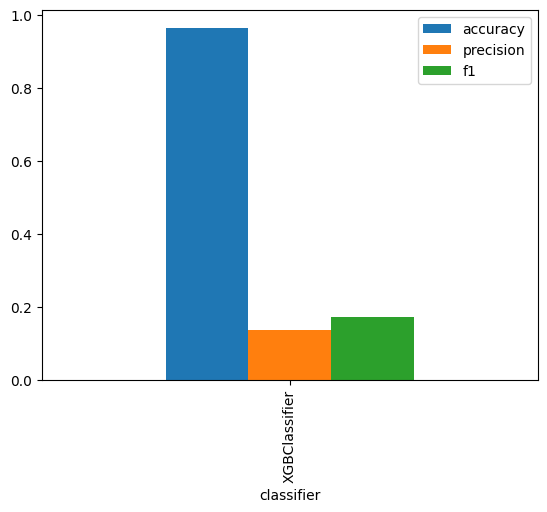

In [6]:
results_df.plot(x='classifier', y=['accuracy', 'precision', 'f1'], kind='bar')

In [7]:
dataset_variants_iterator = list(itertools.product([True, False], repeat=3))
dataset_variants_iterator

[(True, True, True),
 (True, True, False),
 (True, False, True),
 (True, False, False),
 (False, True, True),
 (False, True, False),
 (False, False, True),
 (False, False, False)]

In [ ]:
results = {}
for flatten, enriched, oversampled in tqdm(dataset_variants_iterator):
    # print(f"Flatten: {flatten}, Enriched: {enriched}, Oversampled: {oversampled}")

    results[(flatten, enriched, oversampled)] = {}

    for i in range(EXPERIMENT_COUNT):
        random_state = RANDOM_STATE + i
        classifiers = get_classifiers(random_state=random_state)

        X_train, y_train, X_test, y_test = get_data(dataset, flatten=flatten, enriched=enriched, oversampled=oversampled, scaled=True, random_state=random_state)

        for classifier in classifiers:

            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            classifier_name = classifier.__class__.__name__

            if classifier_name not in results[(flatten, enriched, oversampled)]:
                results[(flatten, enriched, oversampled)][classifier_name] = [[accuracy, precision, f1]]
            else:
                results[(flatten, enriched, oversampled)][classifier_name].append([accuracy, precision, f1])

rows = []
for dataset_variant, clf_dict in results.items():
    for clf_name, scores in clf_dict.items():
        mean_scores = np.mean(scores, axis=0)
        rows.append([dataset_variant, clf_name, mean_scores[0], mean_scores[1], mean_scores[2]])

results_df = pd.DataFrame(rows, columns=['dataset_variant', 'classifier', 'accuracy', 'precision', 'f1'])

100%|██████████| 8/8 [12:56<00:00, 97.05s/it] 


In [8]:
results_df

,dataset_variant,classifier,accuracy,precision,f1
0,"(True, True, True)",RandomForestClassifier,0.97092,0.06944,0.06971
1,"(True, True, True)",AdaBoostClassifier,0.88758,0.07945,0.13941
2,"(True, True, True)",ExtraTreesClassifier,0.97483,0.12500,0.09091
3,"(True, True, True)",BaggingClassifier,0.96477,0.05000,0.05882
4,"(True, True, True)",LogisticRegression,0.86689,0.07235,0.12988
...,...,...,...,...,...
75,"(False, False, False)",SVC,0.98434,0.00000,0.00000
76,"(False, False, False)",DecisionTreeClassifier,0.96555,0.04258,0.04870
77,"(False, False, False)",KNeighborsClassifier,0.97875,0.01389,0.00943
78,"(False, False, False)",LGBMClassifier,0.98266,0.18750,0.03695


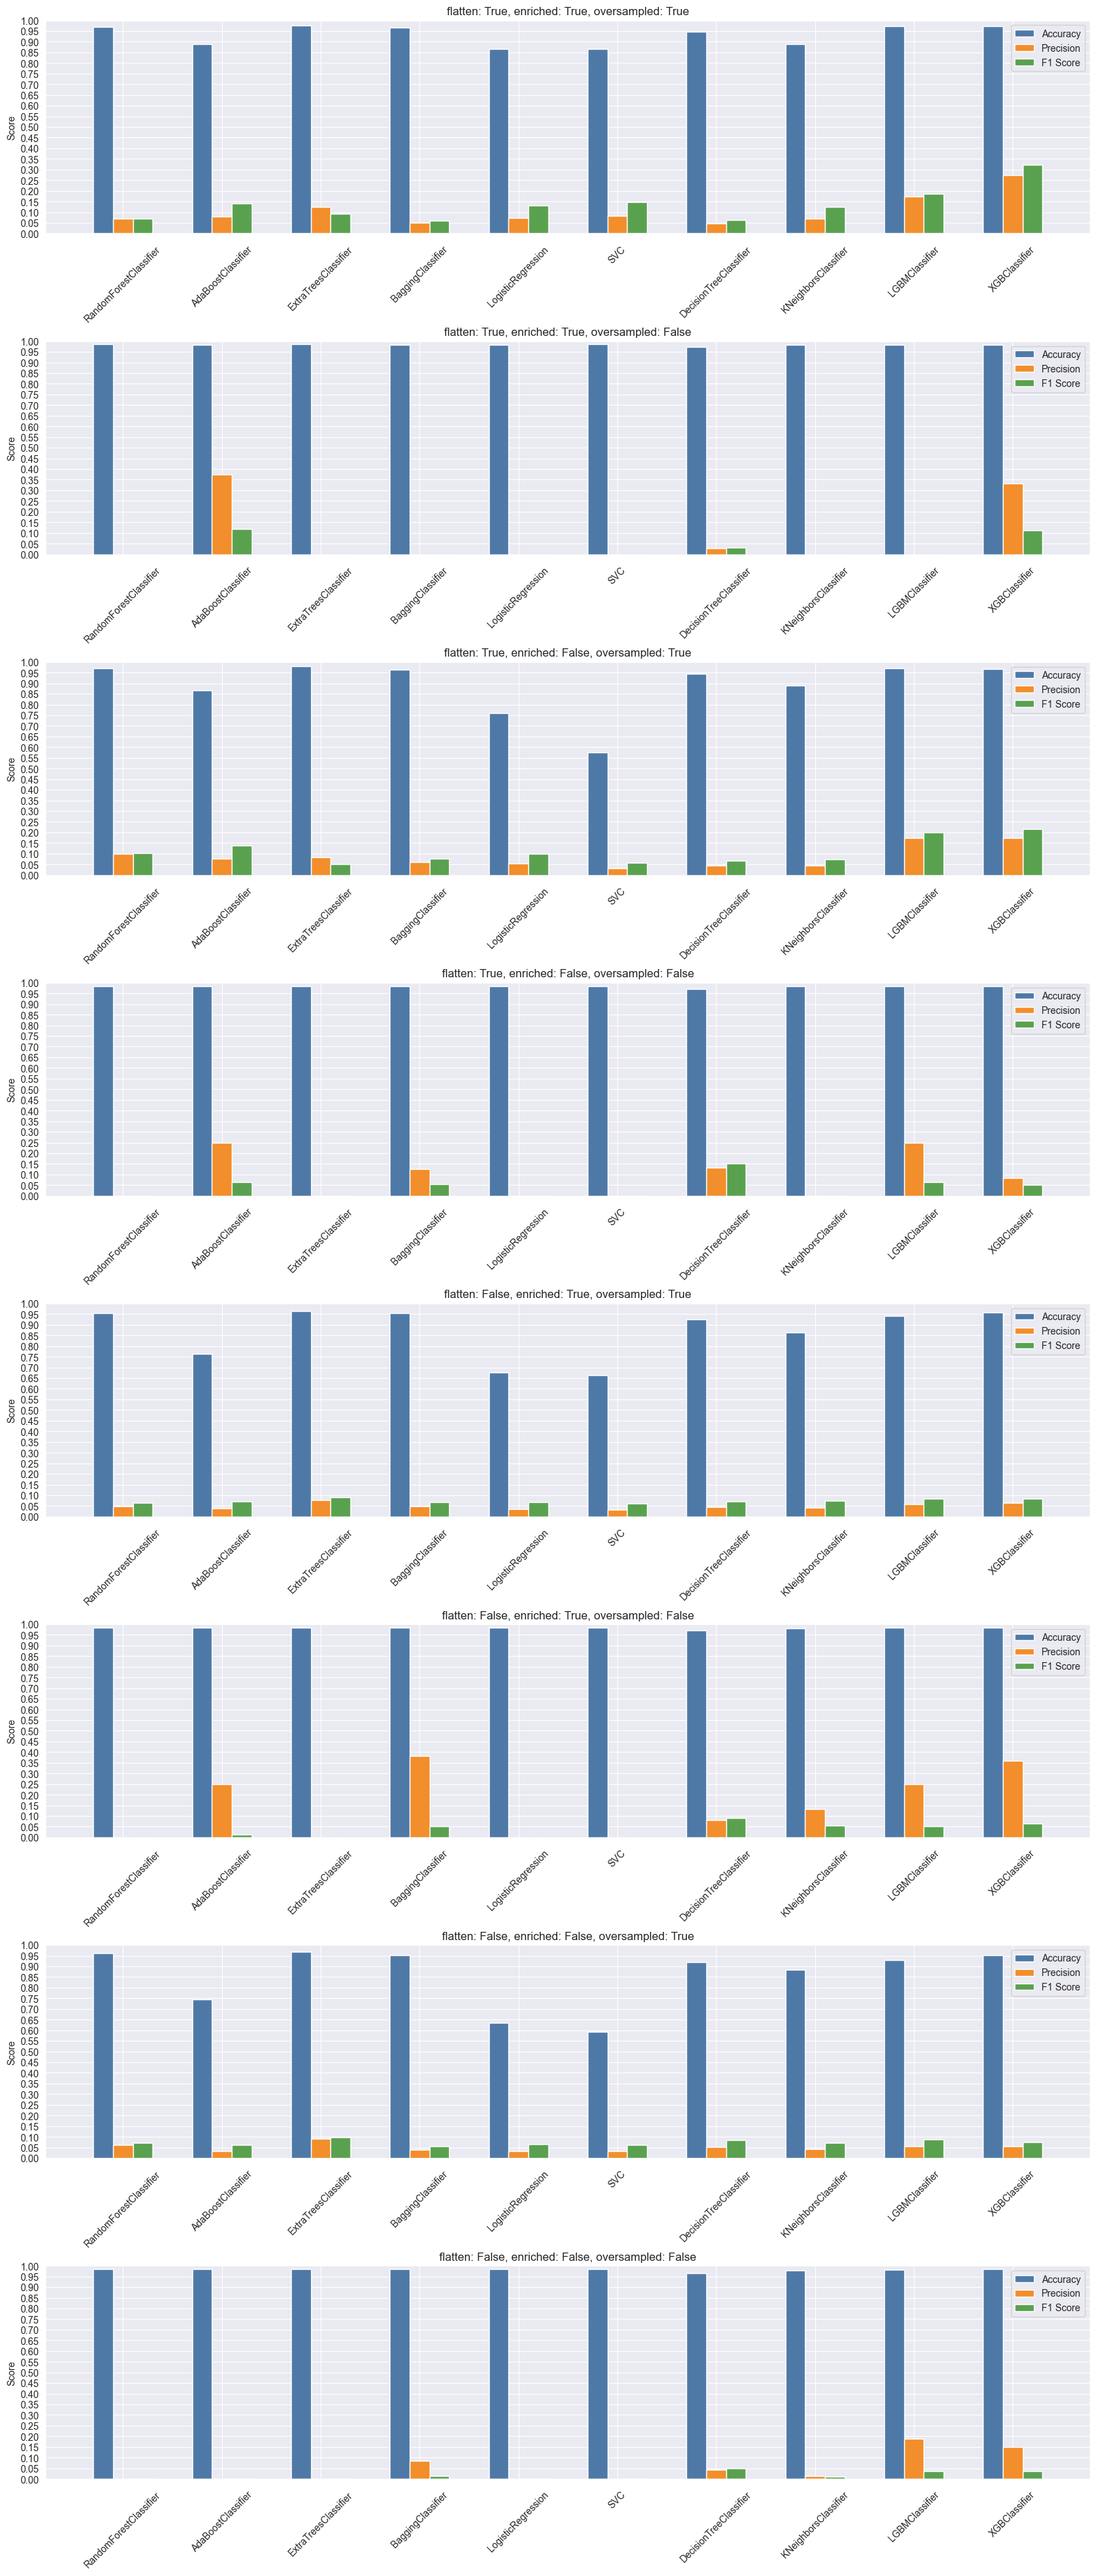

In [10]:
colors = ['#4e79a7', '#f28e2b', '#59a14f']  # Custom colors for bars

dataset_variants = results_df['dataset_variant'].unique()
dataset_variants_length = len(dataset_variants)

fig, axes = plt.subplots(dataset_variants_length, 1, figsize=(16, 5 * dataset_variants_length), sharex=True)
if dataset_variants_length == 1:
    axes = [axes]

for ax, dataset_variant in zip(axes, dataset_variants):
    df_dataset_variant = results_df[results_df['dataset_variant'] == dataset_variant]
    x = np.arange(len(df_dataset_variant['classifier']))
    width = 0.2

    bars1 = ax.bar(x - width, df_dataset_variant['accuracy'], width, label='Accuracy', color=colors[0])
    bars2 = ax.bar(x, df_dataset_variant['precision'], width, label='Precision', color=colors[1])
    bars3 = ax.bar(x + width, df_dataset_variant['f1'], width, label='F1 Score', color=colors[2])
    ax.set_title(f'flatten: {dataset_variant[0]}, enriched: {dataset_variant[1]}, oversampled: {dataset_variant[2]}')
    ax.set_xticks(x)
    ax.set_xticklabels([''] * len(df_dataset_variant['classifier']))
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.05, 0.05))
    ax.legend()

    for idx in range(len(df_dataset_variant['classifier'])):
        ax.text(x[idx], -0.05, df_dataset_variant['classifier'].iloc[idx],
                ha='center', va='top', fontsize=10, rotation=45, clip_on=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

## Finding optimal hyperparameters for best model

In [ ]:
# find best model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

def create_model(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
    model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, random_state=42)
    return model

model = create_model()

param_distributions = {
    'n_estimators': [100],
    'min_samples_split': np.linspace(2, 6, 5).astype(int),
    'min_samples_leaf': np.linspace(2, 6, 5).astype(int),
    'criterion': ['gini', 'entropy', 'log_loss']
}

grid = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=5, scoring='accuracy')

In [ ]:
# save best model

